In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import datasets.Datasets
import models.Feedforward
import models.Attention
import models.DannyCNN
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
# For Patch-to-Pixel

# Make datasets and dataloaders

# setup

radius = 5

importlib.reload(datasets.Datasets)

omit_components = 244 - 244

batch_size = 256

base_data_path = 'Data\\CNN_Data\\Splits'


# load data

emit_train = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_train_pca244.pkl')
)
emit_val = pickle_load(
    os.path.join(base_data_path, 'reflectance_cnn_val_pca244.pkl')
)

elev_train = pickle_load(
    os.path.join(base_data_path, 'elevation_cnn_train.pkl')
)
elev_val = pickle_load(os.path.join(base_data_path, 'elevation_cnn_val.pkl'))

eco_train = pickle_load(os.path.join(base_data_path, 'temp_cnn_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'temp_cnn_val.pkl'))


# create datasets and dataloaders

train_dataset = datasets.Datasets.PatchToPixelDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    radius=radius,
)

val_dataset = datasets.Datasets.PatchToPixelDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    radius=radius,
)

if batch_size is not None:
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, drop_last=True
    )
    val_loader = DataLoader(
        dataset=val_dataset, batch_size=batch_size, drop_last=True
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size
    )
    val_loader = DataLoader(
        dataset=val_dataset, batch_size=batch_size
    )

In [6]:
# For CNN

dropout = 0.25

# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)

model = models.Feedforward.PatchToPixelModel(
    input_dim=train_dataset.input_dim, radius=radius, dropout_rate=dropout
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='mean')

model

PatchToPixelModel(
  (linear1): Linear(in_features=29766, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=1024, bias=True)
  (linear4): Linear(in_features=1024, out_features=1024, bias=True)
  (linear5): Linear(in_features=1024, out_features=512, bias=True)
  (linear6): Linear(in_features=512, out_features=256, bias=True)
  (linear_output): Linear(in_features=256, out_features=1, bias=True)
  (layernorm1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (layernorm4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (layernorm5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layernorm6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
)

In [7]:
importlib.reload(utils.train)

n_epochs = 50

train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 000:     Train (loss, std, K):  1.4303,  1.1959,  3.7581   	 Val (loss, std, K):  1.4395,  1.1998,  6.7106   	LR: 0.0001	Time: 2.71e+02
Epoch 001:     Train (loss, std, K):  0.31711,  0.56312,  1.7696   	 Val (loss, std, K):  0.33391,  0.57785,   3.232   	LR: 0.0001	Time: 4.15e+02
Epoch 002:     Train (loss, std, K):  0.22102,  0.47013,  1.4773   	 Val (loss, std, K):  0.82145,  0.90634,  5.0693   	LR: 0.0001	Time: 4.14e+02
Epoch 003:     Train (loss, std, K):  0.20029,  0.44754,  1.4064   	 Val (loss, std, K):  0.67818,  0.82352,   4.606   	LR: 0.0001	Time: 4.08e+02
Epoch 004:     Train (loss, std, K):  0.16955,  0.41177,  1.2939   	 Val (loss, std, K):  0.74617,  0.86381,  4.8314   	LR: 0.0001	Time: 4.18e+02
Epoch 005:     Train (loss, std, K):  0.15889,  0.39861,  1.2526   	 Val (loss, std, K):  0.81853,  0.90472,  5.0602   	LR:  5e-05	Time: 4.32e+02
Epoch 006:     Train (loss, std, K):  0.1475,  0.38405,  1.2068   	 Val (loss, std, K):  0.44761,  0.66904,   3.742   	LR:  5e-0

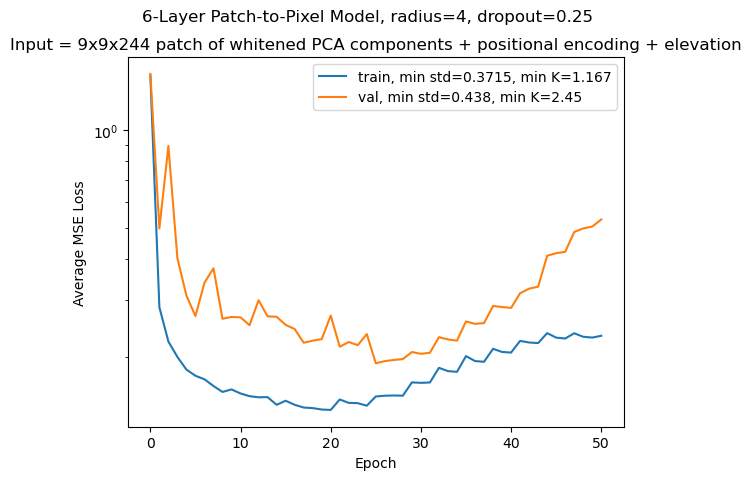

In [8]:
fig, ax = plt.subplots()
fig.suptitle(
    f'6-Layer Patch-to-Pixel Model, radius={radius}, dropout={dropout}'
)
l = 2 * radius + 1
ax.set_title(
    f'Input = {l}x{l}x{244 - omit_components} patch of whitened PCA components'
    ' + positional encoding + elevation'
)
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=(
        'train, '
        # f'min_loss={min(train_loss):.4}, '
        f'min std={min(train_loss)**(1/2):.4}, '
        f'min K={train_dataset.ecostress_scale * min(train_loss)**(1/2):.4}'
    ),
)
ax.semilogy(
    np.arange(len(val_loss)),
    val_loss,
    label=(
        'val, '
        # f'min_loss={min(val_loss):.4}, '
        f'min std={min(val_loss)**(1/2):.4}, '
        f'min K={val_dataset.ecostress_scale * min(val_loss)**(1/2):.4}'
    ),
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)